In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import random
import os
import torch
import torchvision
import torchvision.transforms as transforms
import time

from torchvision import models
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install timm
import timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [4]:
!pip install xmltodict
import xmltodict

**Load Dataset** 

Images are png files, annotations are xml files. 

In [5]:
proj_path = "/content/drive/MyDrive/COM_S_573_Project"
img_path = proj_path + "/data/images/"
xml_path = proj_path + "/data/annotations/"
imgs = sorted([f for f in os.listdir(img_path)])
xmls = sorted([f for f in os.listdir(xml_path)])

Final all the labels from xml files: "without_mask", "with_mask", "mask_weared_incorrect"

In [6]:
listing = []
for f in xmls:
  fd = open(xml_path + f)
  doc = xmltodict.parse(fd.read())
  obj = doc["annotation"]["object"]
  if type(obj) == list:
    for i in range(len(obj)):
      listing.append(obj[i]["name"])
  else:
    listing.append(obj["name"])

mask_labels = list(Counter(listing).keys())
mask_values = list(Counter(listing).values())

print("Labels:", mask_labels)
print("Number of each labels:", mask_values)


Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']
Number of each labels: [717, 3232, 123]


Create final dataset and process to torch tensors.

Add data augmentation.

labels index: {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

In [7]:
class FaceMaskDataset(Dataset):
  def __init__(self, imgs, xmls, img_dir, xml_dir, transform):
    self.images_tensor = []
    self.labels_tensor = []
    for idx in range(len(imgs)):
      img = imgs[idx]
      xml = xmls[idx]
      image = Image.open(img_dir + img).convert("RGB")

      # read annoations
      fd = open(xml_dir + xml)
      doc = xmltodict.parse(fd.read())
      obj = doc["annotation"]["object"]
      if type(obj) == list:
        for i in range(len(obj)):
          xmin, ymin, xmax, ymax = list(map(int, obj[i]["bndbox"].values()))
          img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
          self.images_tensor.append(transform(img))
          lab = mask_labels.index(obj[i]["name"])
          self.labels_tensor.append(torch.tensor(lab))
      else:
        xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
        img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
        self.images_tensor.append(transform(img))
        lab = mask_labels.index(obj["name"])
        self.labels_tensor.append(torch.tensor(lab))

  def __getitem__(self, idx):
    return self.images_tensor[idx], self.labels_tensor[idx]
  
  def __len__(self):
    return len(self.labels_tensor)


Load dataset with dataset loader and split dataset to training data and test data.

**Stratified split dataset.**

In [8]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=10), transforms.ToTensor()])

mask_dataset = FaceMaskDataset(imgs, xmls, img_path, xml_path, transform)

train_indices, test_indices = train_test_split(list(range(len(mask_dataset.labels_tensor))), test_size=0.2, stratify=mask_dataset.labels_tensor)

train_set = torch.utils.data.Subset(mask_dataset, train_indices)
test_set = torch.utils.data.Subset(mask_dataset, test_indices)

mask_train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
mask_test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

**Build Model**

Get GPU device for training

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


Setup models and parameters. We use Swin Transformer.

In [10]:
timm.list_models("swin*")

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224']

In [11]:
class SwinNet(torch.nn.Module):
  def __init__(self, model_name, out_feature, pretrained):
    super().__init__()
    self.model = timm.create_model(model_name, pretrained=pretrained)
    n_features = self.model.head.in_features
    self.model.head = torch.nn.Linear(n_features, out_feature)
  
  def forward(self, x):
    return self.model(x)

swin_transformer = SwinNet("swin_small_patch4_window7_224", 3, True)
swin_transformer = swin_transformer.to(device)

swin_transformer

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_small_patch4_window7_224.pth


SwinNet(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (0): BasicLayer(
        dim=96, input_resolution=(56, 56), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Li

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(swin_transformer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [13]:
# model parameters
swin_transformer_total_params = sum(p.numel() for p in swin_transformer.parameters() if p.requires_grad)
print("Total parameters: ", swin_transformer_total_params)

Total parameters:  48839565


**Train Model**

In [14]:
def train(epoch):
  global train_loss
  global train_acc
  global train_time
  
  running_loss = []
  total = 0
  correct = 0
  start = time.time()

  swin_transformer.train()
  for batch, (images, labels) in enumerate(mask_train_loader):
    if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()
    
    optimizer.zero_grad()
    outputs = swin_transformer(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
    # train acc
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  end = time.time()
  train_loss.append(np.mean(running_loss))
  train_acc.append(correct/total)
  train_time.append(end-start)
  print("training loss %.4f training accuracy %.4f time %.1fs" % (np.mean(running_loss), correct/total, end-start))

**Test**

In [15]:
def test():
  global y_true
  global y_pred

  running_loss = []
  total = 0
  correct = 0

  swin_transformer.eval()
  f1 = 0.0
  with torch.no_grad():
    for images, labels in mask_test_loader:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

      outputs = swin_transformer(images)
      loss = criterion(outputs, labels)
      running_loss.append(loss.item())
      # test acc
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      y_true.extend(labels.cpu().detach().tolist())
      y_pred.extend(predicted.cpu().detach().tolist())

  print("Final testing loss %.4f testing accuracy %.4f" % (np.mean(running_loss), correct/total))  

Train 20 epochs.

In [16]:
num_epochs = 20
train_loss = []
train_acc = []
train_time = []
y_true = []
y_pred = []

for epoch in range(num_epochs):
  print("Epoch...%d/%d" % (epoch+1, num_epochs))
  train(epoch)

test()

Epoch...1/20
training loss 0.3926 training accuracy 0.8625 time 176.0s
Epoch...2/20
training loss 0.1552 training accuracy 0.9490 time 175.4s
Epoch...3/20
training loss 0.1205 training accuracy 0.9598 time 175.7s
Epoch...4/20
training loss 0.0899 training accuracy 0.9690 time 175.3s
Epoch...5/20
training loss 0.0718 training accuracy 0.9770 time 175.3s
Epoch...6/20
training loss 0.0601 training accuracy 0.9816 time 175.3s
Epoch...7/20
training loss 0.0483 training accuracy 0.9846 time 175.4s
Epoch...8/20
training loss 0.0402 training accuracy 0.9865 time 175.6s
Epoch...9/20
training loss 0.0419 training accuracy 0.9874 time 175.5s
Epoch...10/20
training loss 0.0307 training accuracy 0.9914 time 175.6s
Epoch...11/20
training loss 0.0210 training accuracy 0.9942 time 175.3s
Epoch...12/20
training loss 0.0132 training accuracy 0.9957 time 175.6s
Epoch...13/20
training loss 0.0070 training accuracy 0.9988 time 175.6s
Epoch...14/20
training loss 0.0119 training accuracy 0.9975 time 175.5s
E

Save training process.

In [17]:
epochs = list(range(1, num_epochs+1))

dict = {"epoch": epochs, "train_loss": train_loss, "train_acc": train_acc, "train_time": train_time}
df = pd.DataFrame(dict)
df.to_csv(proj_path + "/models/swin_transformer_train.csv")

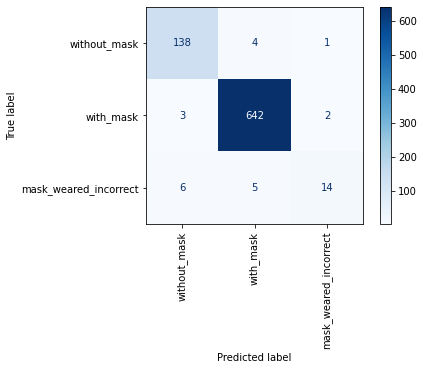

In [18]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=mask_labels, cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.savefig(proj_path + "/images/swin_cm.png", dpi=400, bbox_inches='tight')
plt.show()

In [19]:
cr = classification_report(y_true, y_pred, target_names=mask_labels)
print(cr)

                       precision    recall  f1-score   support

         without_mask       0.94      0.97      0.95       143
            with_mask       0.99      0.99      0.99       647
mask_weared_incorrect       0.82      0.56      0.67        25

             accuracy                           0.97       815
            macro avg       0.92      0.84      0.87       815
         weighted avg       0.97      0.97      0.97       815

